In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
# Import modules
from elastica.modules import BaseSystemCollection, Constraints, Forcing, Damping

# Import Cosserat Rod Class
from elastica.rod.cosserat_rod import CosseratRod

# Import Damping Class
from elastica.dissipation import AnalyticalLinearDamper

# Import Boundary Condition Classes
from elastica.boundary_conditions import OneEndFixedRod, FreeRod
from elastica.external_forces import EndpointForces 
from elastica.external_forces import GravityForces

# Import Timestepping Functions
from elastica.timestepper.symplectic_steppers import PositionVerlet 
from elastica.timestepper import extend_stepper_interface
from elastica.timestepper import integrate 

from analytical_result import analytical_result

In [8]:
%matplotlib inline
loops = 10
softer_angle = np.zeros(loops)
stiffer_angle = np.zeros(loops)
analytical_softer_angle = np.zeros(loops)
analytical_stiffer_angle = np.zeros(loops)
end_force_zs = np.linspace(1e5,1e8,loops)
for i in range(loops):
    class PendulumSimulator(BaseSystemCollection, Constraints, Forcing, Damping):
        pass 

    Pendulum_Sim = PendulumSimulator()

    # Create Rod 
    n_elem = 40
    #--------------mGS Unit-----------------
    # density = 1200* 1e-6 * 1000000 #mGS
    # gravitational_acc = -9.80665e0 * 1e3 /1000000 #mGS
    # base_length = 10 #mGS 
    # base_radius = 1 #mGS
    # E = 1.2e9
    #--------------CGS Unit------------------
    # density = 2273* 1e-3   #g/cm^3
    # gravitational_acc = -9.80665e0 * 1e2  #cm/s^2
    # base_length = 0.3 # cm
    # base_radius = 0.06 # cm
    # E = 1.4e6* 10 # g/(cm*s)
    #--------------SI Unit------------------
    # density = 1200 * 1000000 #SI
    # gravitational_acc = -9.80665e0  /1000000 #SI
    # base_length = 10e-3 #SI 
    # base_radius = 1e-3 #SI
    # E = 1.2e9 #SI
    #--------------mmGS Unit------------------
    density = 2.273 # mg/mm^3
    gravitational_acc = -9.80665e3  #mm/s^2
    base_length = 6 #mm 
    base_radius = 0.3 #mm
    E_scale = 1e-4
    E = 1.4e9*E_scale # mg/(mm*s^2)


    dl = base_length / n_elem 
    # dt = 0.002 * dl 
    dt = 1.0e-5
    nu = 1500 #damping constant
    shear_modulus = E / (3.0)

    start = np.array([0.0,0.0,0.0])
    direction = np.array([0.0, 1.0, 0.0])
    normal = np.array([1.0, 0.0, 0.0])
    base_area = np.pi * base_radius**2
    # base_area = base_radius*np.sqrt(3)/3

    origin_force = np.array([0.0, 0.0, 0.0])
    end_force = E_scale*np.array([0.0, 0.0, -end_force_zs[i]])
    ramp_up_time = 0.1

    softer_rod = CosseratRod.straight_rod(
        n_elem,
        start,
        direction,
        normal,
        base_length,
        base_radius,
        density,
        youngs_modulus=E,
        shear_modulus = shear_modulus,
    )

    stiffer_rod = CosseratRod.straight_rod(
        n_elem,
        start,
        direction,
        normal,
        base_length,
        base_radius,
        density,
        youngs_modulus = E*10,
        shear_modulus = shear_modulus*10,
    )


    Pendulum_Sim.append(softer_rod)
    Pendulum_Sim.append(stiffer_rod)
    Pendulum_Sim.dampen(softer_rod).using(
        AnalyticalLinearDamper,
        damping_constant = nu,
        time_step = dt,
    )
    Pendulum_Sim.dampen(stiffer_rod).using(
        AnalyticalLinearDamper,
        damping_constant = nu,
        time_step = dt,
    )

    Pendulum_Sim.constrain(softer_rod).using(
        OneEndFixedRod,constrained_position_idx = (0,), constrained_director_idx= (0,)
    )
    Pendulum_Sim.constrain(stiffer_rod).using(
        OneEndFixedRod,constrained_position_idx = (0,), constrained_director_idx= (0,)
    )
    print("One end of the rod is now fixed in place")

    # Pendulum_Sim.add_forcing_to(softer_rod).using(
    #     GravityForces, acc_gravity = np.array([0.0,0.0,gravitational_acc]) 
    # )
    # Pendulum_Sim.add_forcing_to(stiffer_rod).using(
    #     GravityForces, acc_gravity = np.array([0.0,0.0,gravitational_acc]) 
    # )

    Pendulum_Sim.add_forcing_to(softer_rod).using(
        EndpointForces, origin_force, end_force, ramp_up_time = ramp_up_time
    )
    Pendulum_Sim.add_forcing_to(stiffer_rod).using(
        EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
    )
    print("Forces added to the rod")

    Pendulum_Sim.finalize()
    print("System finalized")

    #----------------------------time integration----------------------------------
    final_time = 4
    total_steps = int(final_time / dt)
    timestepper = PositionVerlet()
    integrate(timestepper, Pendulum_Sim, final_time, total_steps)

    softer_angle[i] = np.arctan(-softer_rod.position_collection[2,-1] / softer_rod.position_collection[1,-1]) / (2*np.pi) * 360
    stiffer_angle[i] = np.arctan(-stiffer_rod.position_collection[2,-1] / stiffer_rod.position_collection[1,-1]) / (2*np.pi) * 360

    analytical_softer_position = analytical_result(softer_rod, end_force, shearing=False, n_elem=500)
    analytical_stiffer_position = analytical_result(stiffer_rod, end_force, shearing=False, n_elem=500)
    analytical_softer_angle[i] = np.arctan(-analytical_softer_position[1][-1]/analytical_softer_position[0][-1])/ (2*np.pi) * 360
    analytical_stiffer_angle[i] = np.arctan(-analytical_stiffer_position[1][-1]/analytical_stiffer_position[0][-1]) / (2*np.pi) * 360

One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 399999/399999 [00:22<00:00, 17909.95it/s]


Final time of simulation is :  4.000000000002014
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 399999/399999 [00:22<00:00, 17506.00it/s]


Final time of simulation is :  4.000000000002014
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 399999/399999 [00:22<00:00, 17602.92it/s]


Final time of simulation is :  4.000000000002014
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 399999/399999 [00:23<00:00, 16958.47it/s]


Final time of simulation is :  4.000000000002014
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 399999/399999 [00:23<00:00, 17160.84it/s]


Final time of simulation is :  4.000000000002014
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 399999/399999 [00:23<00:00, 16897.18it/s]


Final time of simulation is :  4.000000000002014
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 399999/399999 [00:23<00:00, 16945.11it/s]


Final time of simulation is :  4.000000000002014
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 399999/399999 [00:23<00:00, 17068.02it/s]


Final time of simulation is :  4.000000000002014
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 399999/399999 [00:23<00:00, 17144.94it/s]


Final time of simulation is :  4.000000000002014
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 399999/399999 [00:23<00:00, 16878.48it/s]

Final time of simulation is :  4.000000000002014


In [18]:
np.arctan(4*end_force_zs*E_scale*base_length**2/(30*E*base_radius**4*np.pi))/np.pi*180

array([ 0.77192422, 56.46837186, 71.59123296, 77.47153489, 80.53098076,
       82.39656901, 83.65055813, 84.55055338, 85.22760295, 85.75528277])

In [9]:
print(analytical_stiffer_angle, stiffer_angle)

[ 0.77192422 56.46837186 71.59123296 77.47153489 80.53098076 82.39656901
 83.65055813 84.55055338 85.22760295 85.75528277] [ 0.20538368 21.67904932 37.98047996 49.31030069 57.2012045  62.81368555
 66.89679467 69.93147276 72.2331573  74.01344784]


In [10]:
print(analytical_softer_angle,softer_angle)

[ 7.67349868 86.20866832 88.09375299 88.72700591 89.04447062 89.2352073
 89.36247009 89.45342275 89.52166466 89.57475781] [ 0.28590149 26.78331696 42.71750224 53.32414952 60.92019424 66.5895655
 70.9230465  74.28476108 76.92213715 79.01218645]


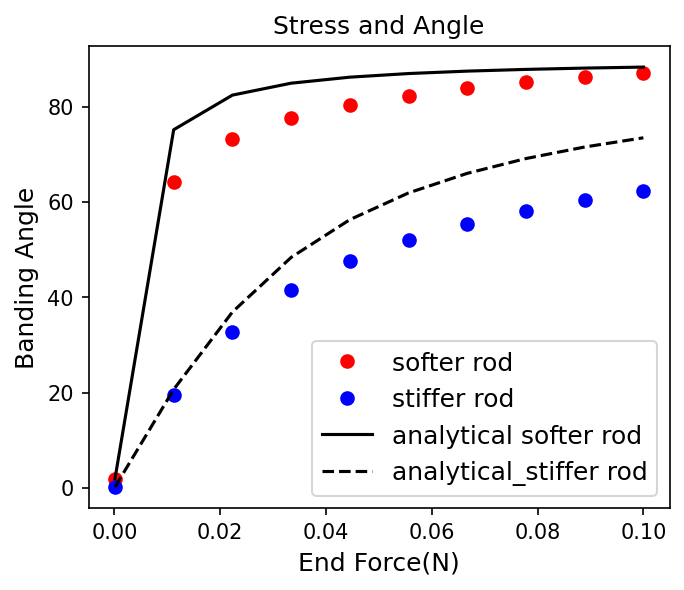

In [18]:
%matplotlib inline
# update the plot every 0.1 second
fig = plt.figure(figsize=(5,4), frameon=True, dpi=150)
ax = fig.add_subplot(111)
ax.plot(
    end_force_zs*1e-9,
    softer_angle,
    "ro",
    label = "softer rod"
)
ax.plot(
    end_force_zs*1e-9,
    stiffer_angle,
    "bo",
    label = "stiffer rod"
)
ax.plot(
    end_force_zs*1e-9,
    analytical_softer_angle,
    "k-",
    label = "analytical softer rod"
)
ax.plot(
    end_force_zs*1e-9,
    analytical_stiffer_angle,
    "k--",
    label = "analytical_stiffer rod"
)
ax.legend(prop={"size":12}, loc="lower right")
ax.set_ylabel("Banding Angle", fontsize=12)
ax.set_xlabel("End Force(N)", fontsize=12)
ax.set_title("Stress and Angle")
plt.savefig('Stress_Angle_Approx_4.jpg')
plt.show()
plt.close()